In [1]:
!pip install rdkit

     --------------------------------------- 20.7/20.7 MB 21.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [45]:


import rdkit
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem

from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

rdkit.__version__

'2023.03.1'

In [4]:
df_smiles = pd.read_csv('tested_molecules-1.csv')
print(df_smiles)

                                                SMILES  ALDH1_inhibition
0    COc1ccccc1CC(NC(C)=O)C(=O)NC1CCN(c2nnnn2-c2ccc...                 1
1               O=C(CSc1nc2cccnc2n1Cc1ccccc1)NCc1ccco1                 1
2    Cc1cccc2cc(C[NH+](CC3CCCO3)C(c3nnnn3Cc3ccco3)C...                 1
3                    CCN(CC)c1ccc2c(Cl)c(Br)c(=O)oc2c1                 1
4    CS(=O)(=O)N1CCc2cc(-c3csc(NC(=O)Cc4cccs4)n3)ccc21                 1
..                                                 ...               ...
995             COc1ccc(N2C(=O)CC([NH2+]C3CC3)C2=O)cc1                 0
996                       CCNc1oc(COc2cccc(C)c2)nc1C#N                 0
997                          NC(=O)Cn1cnc(-c2ccccc2)c1                 0
998  Cc1cc(NC(=O)CSc2nc3c(c(=O)n(C)c(=O)n3C)n2C(C)C...                 0
999          O=C(Cn1nnc2c(cnn2-c2ccccc2)c1=O)NCc1cccs1                 0

[1000 rows x 2 columns]


Example molecule

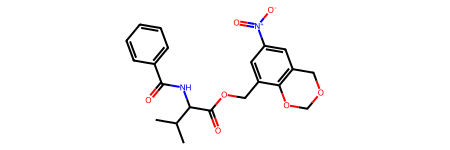

In [5]:
mol = Chem.MolFromSmiles(df_smiles.iloc[566]['SMILES'])
print(mol)
mol

In [6]:
def getMolDescriptors(mol, missingVal=None):
    ''' calculate the full list of descriptors for a molecule
    
        missingVal is used if the descriptor cannot be calculated
    '''
    res = {}
    for nm,fn in Descriptors._descList:
        # some of the descriptor fucntions can throw errors if they fail, catch those here:
        try:
            val = fn(mol)
        except:
            # print the error message:
            import traceback
            traceback.print_exc()
            # and set the descriptor value to whatever missingVal is
            val = missingVal
        res[nm] = val
    return res

In [7]:
getMolDescriptors(mol)

{'MaxAbsEStateIndex': 12.675380920886873,
 'MaxEStateIndex': 12.675380920886873,
 'MinAbsEStateIndex': 0.007449874403684387,
 'MinEStateIndex': -0.8782572751322746,
 'qed': 0.42042622795544143,
 'MolWt': 414.4140000000002,
 'HeavyAtomMolWt': 392.23800000000017,
 'ExactMolWt': 414.1427010439999,
 'NumValenceElectrons': 158,
 'NumRadicalElectrons': 0,
 'MaxPartialCharge': 0.3287506360220477,
 'MinPartialCharge': -0.4667283975223054,
 'MaxAbsPartialCharge': 0.4667283975223054,
 'MinAbsPartialCharge': 0.3287506360220477,
 'FpDensityMorgan1': 1.2333333333333334,
 'FpDensityMorgan2': 1.9666666666666666,
 'FpDensityMorgan3': 2.6333333333333333,
 'BCUT2D_MWHI': 16.66948628102663,
 'BCUT2D_MWLOW': 10.035134652070933,
 'BCUT2D_CHGHI': 2.2750499957428487,
 'BCUT2D_CHGLO': -2.2266063845716886,
 'BCUT2D_LOGPHI': 2.327464463393052,
 'BCUT2D_LOGPLOW': -2.448396304226626,
 'BCUT2D_MRHI': 5.963307032019093,
 'BCUT2D_MRLOW': -0.3846085007928553,
 'AvgIpc': 2.7502304471817247,
 'BalabanJ': 1.733543449610

In [8]:
allDescrs = []
for _, row in df_smiles.iterrows():
    mol = row['SMILES']
    m = Chem.MolFromSmiles(mol)
    descriptors = getMolDescriptors(m)
    allDescrs.append(descriptors)
    
df_descr = pd.DataFrame(allDescrs)
df_descr.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,13.083531,13.083531,0.001173,-0.683140,0.520365,463.542,434.310,463.233188,178,0,...,0,0,0,0,1,0,0,0,0,0
1,12.170097,12.170097,0.066966,-0.066966,0.498564,378.457,360.313,378.115047,136,0,...,1,0,0,0,0,0,0,0,0,0
2,10.905837,10.905837,0.016881,-0.016881,0.382043,477.589,444.325,477.260865,184,0,...,0,0,0,0,1,0,0,0,0,0
3,11.562446,11.562446,0.270607,-0.454447,0.795948,330.609,317.505,328.981818,96,0,...,0,0,0,0,0,0,0,0,0,0
4,12.108866,12.108866,0.086947,-3.251317,0.687618,419.553,402.417,419.043204,140,0,...,0,1,0,0,0,1,0,1,0,0


Delete the collumns that have only one unique value, so a column where each value is the mean, and variance is 0

In [9]:
#Deletes colums with nonsense values (only the same values)
bad_descr=[]
for i in df_descr.columns:
    if df_descr[i].nunique() == 1:
        bad_descr.append(i)
print(bad_descr)       
df_nonzero=df_descr.drop(columns=bad_descr)  

['NumRadicalElectrons', 'SMR_VSA8', 'SlogP_VSA9', 'EState_VSA11', 'fr_HOCCN', 'fr_azide', 'fr_benzodiazepine', 'fr_diazo', 'fr_dihydropyridine', 'fr_epoxide', 'fr_isocyan', 'fr_isothiocyan', 'fr_phos_acid', 'fr_phos_ester', 'fr_prisulfonamd']


Remove variables so that no variables are left that have a corralation with another variable higher than the set threshold for corralarion

In [29]:
corrThreshold = 0.90


correlation_mat = df_nonzero.corr()
upper_tri = correlation_mat.where(np.triu(np.ones(correlation_mat.shape),k=1).astype(bool)) 
to_drop = [column for column in upper_tri.columns if any(upper_tri[column].abs() > corrThreshold)] 
df_noCorr = df_nonzero.drop(columns=to_drop)



df_noCorr.head()

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,BCUT2D_MWLOW,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,13.083531,0.001173,-0.683140,0.520365,463.542,0.249868,-0.496477,1.088235,16.465857,10.012387,...,0,0,0,0,1,0,0,0,0,0
1,12.170097,0.066966,-0.066966,0.498564,378.457,0.230353,-0.467476,1.111111,32.166556,10.202245,...,1,0,0,0,0,0,0,0,0,0
2,10.905837,0.016881,-0.016881,0.382043,477.589,0.219930,-0.492903,1.228571,16.492058,9.989823,...,0,0,0,0,1,0,0,0,0,0
3,11.562446,0.270607,-0.454447,0.795948,330.609,0.351723,-0.421732,1.333333,79.918731,10.173315,...,0,0,0,0,0,0,0,0,0,0
4,12.108866,0.086947,-3.251317,0.687618,419.553,0.231765,-0.301646,1.296296,32.233291,10.071048,...,0,1,0,0,0,1,0,1,0,0


In [30]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_noCorr)

pca = PCA(n_components=50)
principalComponents = pca.fit_transform(df_scaled)
principalDf = pd.DataFrame(data = principalComponents)
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

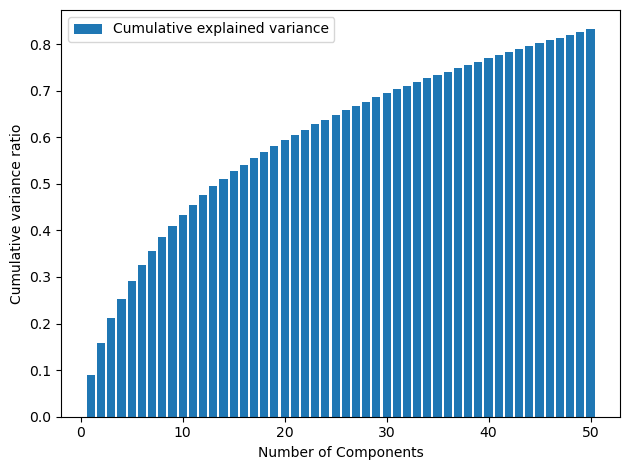

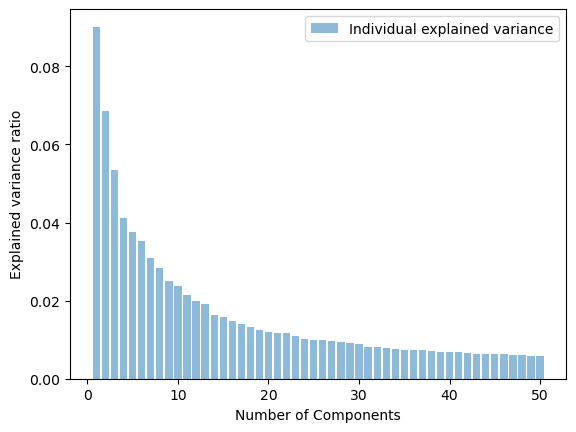

In [12]:
plt.bar(range(1,len(cum_sum_eigenvalues)+1), cum_sum_eigenvalues, align='center',label='Cumulative explained variance')
plt.ylabel('Cumulative variance ratio')
plt.xlabel('Number of Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

#scree plot om aantal PCA te bepalen
plt.bar(range(1,len(exp_var_pca)+1), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Number of Components')
plt.legend(loc='best')

In [13]:
def good_correlation(df1, treshold=0.3):
    cm = df1.corr() #correlation matrix
    np.fill_diagonal(cm.values, 0) # set diagonal to 0 
    corr = [(cm.index[x], cm.columns[y], cm.iloc[x,y]) for x, y in zip(*np.where(abs(np.tril(cm)) > treshold))] # create couple (feature1, feature2, value)
    for couple in corr:
        feature1, feature2, value = couple
        #print(f'{feature1} and {feature2} are strongly correlated (treshold = {treshold}) (value = {value})')

    return cm, corr


In [14]:
good_correlation(df_noCorr, treshold=0.9)[1]

[]

In [15]:
#verwijderen van features die lage variance hebben
#x is hierbij je matrix met alle features.
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8*(1-.8)))
df_noCorr = selection.fit_transform(df_noCorr)


perform random forest method

In [76]:
principalDf
column_names = list(principalDf.columns)
column_names

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49]

In [43]:
labels = np.array(df_smiles['ALDH1_inhibition'])
features = np.array(principalDf)

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.20, random_state = 42)

#check the shapes
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (800, 50)
Training Labels Shape: (800,)
Testing Features Shape: (200, 50)
Testing Labels Shape: (200,)


train model

In [46]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

make predictions

In [55]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)

predictions
# Print out the mean absolute error (mae)
#print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

array([0.144, 0.536, 0.375, 0.527, 0.221, 0.41 , 0.311, 0.179, 0.199,
       0.085, 0.412, 0.47 , 0.1  , 0.342, 0.322, 0.232, 0.312, 0.254,
       0.38 , 0.453, 0.327, 0.507, 0.382, 0.364, 0.549, 0.249, 0.278,
       0.297, 0.302, 0.207, 0.187, 0.487, 0.423, 0.393, 0.453, 0.506,
       0.194, 0.382, 0.38 , 0.497, 0.227, 0.189, 0.423, 0.311, 0.277,
       0.244, 0.116, 0.174, 0.329, 0.271, 0.207, 0.207, 0.431, 0.136,
       0.138, 0.474, 0.459, 0.343, 0.295, 0.088, 0.268, 0.266, 0.369,
       0.34 , 0.392, 0.107, 0.468, 0.35 , 0.432, 0.058, 0.519, 0.136,
       0.274, 0.414, 0.14 , 0.494, 0.095, 0.449, 0.276, 0.271, 0.272,
       0.451, 0.391, 0.303, 0.235, 0.337, 0.267, 0.269, 0.274, 0.487,
       0.233, 0.4  , 0.247, 0.075, 0.314, 0.439, 0.318, 0.388, 0.376,
       0.388, 0.295, 0.333, 0.212, 0.349, 0.3  , 0.317, 0.482, 0.261,
       0.475, 0.327, 0.349, 0.429, 0.355, 0.255, 0.309, 0.42 , 0.493,
       0.506, 0.08 , 0.399, 0.196, 0.408, 0.229, 0.326, 0.342, 0.339,
       0.381, 0.328,

andere methode rf

In [85]:
clf=RandomForestClassifier()
clf.fit(train_features, train_labels)
preds = clf.predict(test_features)
preds
print (clf.score(train_features, train_labels))
print("accuracy is" ,clf.score(test_features, test_labels))

1.0
accuracy is 0.7


In [84]:
#determine which pc is most important, order
pd.DataFrame(clf.feature_importances_, index=principalDf.columns).sort_values(by=0, ascending=False)

,0
7,0.031684
0,0.029244
46,0.029078
43,0.024031
23,0.023654
9,0.023228
33,0.023055
27,0.022680
10,0.022616
18,0.022546
